# Chapter 3: Kriging (estimation and prediction)

In the previous Tutorial, we used the GeoGals package to fit a geostatistical (Gaussian Process) model to our sample galaxy. In this Tutorial, we show how we can use this model to predict the values of the metallicity of our galaxy at locations where no metallicity has been measured. 

As in the previous examples, our first step is to load in our packages and our data:

In [1]:
import geogals as gg
from astropy.io import fits
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [13]:
data_path = '../../data/' # You may need to change this on your own computer.
Z_data    = fits.open(data_path + 'NGC1385_metals.fits')

# Don't forget your metadata!
metadata = {
    'RA':54.3680,
    'DEC':-24.5012,
    'PA': 181.3,
    'i': 44.0,
    'D': 22.7
}

# Convert to dict; take a subsample (sacrificing accuracy for computational speed)
Z_dict = gg.to_data_dict(Z_data[0].header, Z_data[0].data, Z_data[1].data)
Z_dict = gg.get_subsample(Z_dict, n_in_subsample=1000)

Next, we plot our galaxy metallicity data, together with the location of the point where we will be predicting the metallicity:

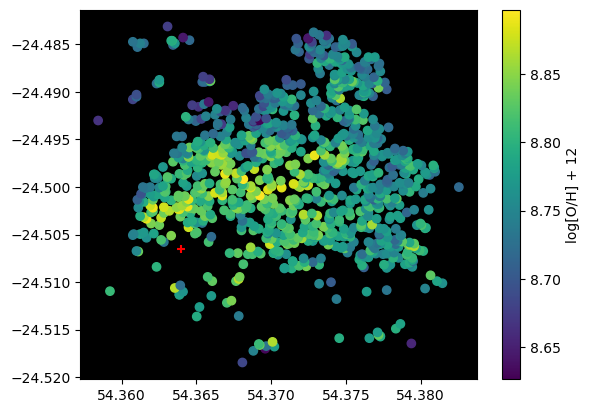

In [14]:
target_RA  = np.array([54.364])
target_DEC = np.array([-24.5065])

fig, ax = plt.subplots()
plt.scatter(Z_dict['RA'], Z_dict['DEC'], c=Z_dict['Z'])
plt.colorbar(label= 'log[O/H] + 12')
plt.scatter(target_RA, target_DEC, color='red', marker='+')
ax.set_facecolor('black')

To predict the value of our field at this location, we need to supply the best estimate for $\theta$, our vector of parameters, as computed in the last tutorial. Once we have this point, we are ready to use kriging to estimate the metallicity of this point.

Kriging works by using the modelled spatial structure of the data. By understanding how data points are expected to be correlated with each other, we can use our measured data point values to predict the true values of the data field at unmeasured locations. II practise, this means that the fitted value of the uncertain point will be expected to be close to the value of points that are nearby. If there are no points nearby, then the best fitted value will be the value of the mean function of the galaxy at that location (determined by the metallicity gradient in this example).

In [15]:
theta = [-4.12820033e-01,  1.37474974e+02,  8.90581095e+00, -1.46253469e-02]

Z_est, var_Z_est = gg.krig_exp_model(target_RA, target_DEC, Z_dict, metadata, theta, mode='list')

print('Z = {0:.3f} +/- {1:.3f}'.format(Z_est[0], np.sqrt(var_Z_est[0])))

Z = 8.804 +/- 0.044


The `mode='list'` argument tells us that we are taking as input a list of points (in our example, our list is only one point long). This is ideally suited for the task of estimating the metallicity of a specific point of interest within a galaxy -- for example, at the site of a particularly iteresting supernova. If we instead want a metallicity estimate at every location of our galaxy, we can run our function in `'grid'` mode, inputting a grid of RA and DEC values that we have constructed.

In [24]:
grid_length = 100 # This will give us a total of 10,000 samples

RA_list  = np.linspace(np.min(Z_dict['RA']),  np.max(Z_dict['RA']),  grid_length)
DEC_list = np.linspace(np.min(Z_dict['DEC']), np.max(Z_dict['DEC']), grid_length)

RA_grid, DEC_grid = np.meshgrid(RA_list, DEC_list)

Z_grid, var_Z_grid = gg.krig_exp_model(RA_grid, DEC_grid, Z_dict, metadata, theta, mode='grid')

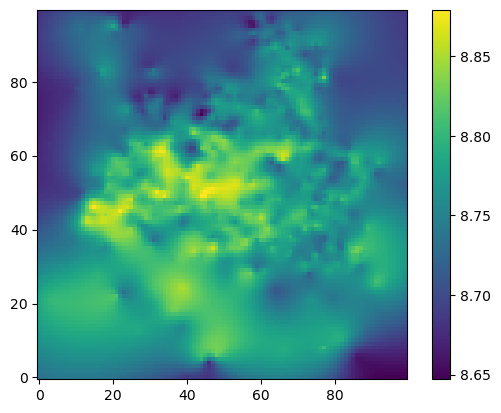

In [25]:
plt.imshow(Z_grid, origin='lower')
plt.colorbar(label= 'log[O/H] + 12')

This analysis provides better insights into the complicated metallicity distribution of a galaxy, and increases the completeness of a metallicity survey. Kriging has also been show to produce better predictions of the metallicity of a galaxy at held-out points compared to a linear model that ignores small-scale features [(Metha et al. 2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.514.4465M/abstract).

We can see that this model becomes less detailed as we move further from the central region of our galaxy, where we have the most data. Plotting the variance array, we can also see that our model gets more and more uncertain as we move away from the regions where we have a lot of measurements:

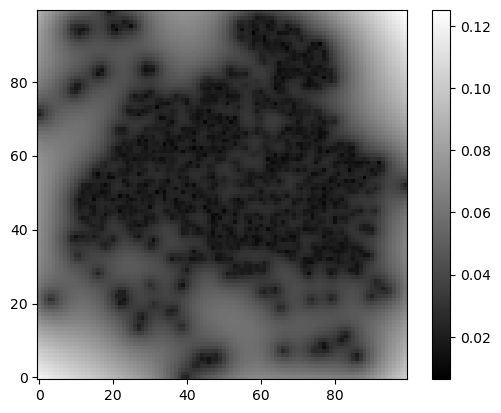

In [26]:
plt.imshow(np.sqrt(var_Z_grid), origin='lower', cmap='grey')

plt.colorbar()

We can also use kriging to estimate the most likely values of the metallicity at locations where it has already been measured. This approach exploits the learned correlation structure of the random field to get better estimates of the metallicity at all locations.

In [ ]:
better_Z_est, unc_better_Z_est = gg.krig_exp_model(None, None, Z_dict, metadata, theta, mode='auto')

This brings us to the end of our Tutorials. Please feel free to open a pull request